In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import pandas as pd
import pandas_datareader.data as web

from typing import Any
from typing import Optional
from typing import Tuple
from uuid import uuid4
import datetime
import time

In [2]:
DEVICE = 'cpu'
DTYPE = torch.float32

In [3]:
class ContextsManager:
    def __init__(self):
        self.contexts = {}
    
    def init_ctx_with_id(self, cid: str, shape: torch.Size, device: Any, init_with: Any = 'zeros') -> None:
        if init_with == 'zeros':
            ctx = torch.zeros(shape, dtype=DTYPE, device=device)
        elif init_with == 'randn':
            ctx = torch.randn(shape, dtype=DTYPE, device=device)
        elif isinstance(init_with, torch.Tensor):
            ctx = torch.clone(init_with)
        else:
            raise RuntimeError('init_with argument should be either "zeros", "randn" or a tensor.')
        self.contexts[cid] = ctx
    
    def get_ctx(self, cid: str) -> Optional[torch.Tensor]:
        return self.contexts.get(cid, None)
    
    def set_ctx(self, cid: str, ctx: torch.Tensor) -> None:
        self.contexts[cid] = ctx
    
    def del_ctx(self, cid: str) -> None:
        del self.contexts[cid]

In [69]:
class PRForecaster(nn.Module):
    def __init__(self, ctx_manager: ContextsManager, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.ctx_manager = ctx_manager
        self.cid = str(uuid4())
    
    def get_ctx_shape(self) -> Optional[torch.Size]:
        return None
    
    def init_context(self, batch_size: int, device: Any, init_with: Any = 'zeros'):
        baseline_shape = self.get_ctx_shape()
        if baseline_shape is None:
            return
        ctx_shape = torch.Size([batch_size] + list(baseline_shape))
        self.ctx_manager.init_ctx_with_id(self.cid, ctx_shape, device, init_with)
    
    def delete_context(self):
        if self.get_ctx_shape() is not None:
            self.ctx_manager.del_ctx(self.cid)
    
    def forward(self, inp: torch.Tensor, prev_errors: Optional[torch.Tensor] = None, **kwargs) -> torch.Tensor:
        ctx = self.ctx_manager.get_ctx(self.cid)
        out, new_ctx = self._forward(inp, ctx, prev_errors, **kwargs)
        self.ctx_manager.set_ctx(self.cid, new_ctx)
        return out
    
    def _forward(self, inp: torch.Tensor,
                 ctx: torch.Tensor, prev_errors: Optional[torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        pass

In [70]:
class LinearForecaster(PRForecaster):
    def __init__(self, ctx_manager: ContextsManager, inp_len: int, *args, **kwargs):
        super().__init__(ctx_manager, *args, **kwargs)
        self.predictor = nn.Linear(inp_len, 1, dtype=DTYPE)
    
    def _forward(self, inp: torch.Tensor,
                 ctx: torch.Tensor, prev_errors: Optional[torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.predictor(inp), None

In [71]:
class RSPForecaster(PRForecaster):
    def __init__(self, ctx_manager: ContextsManager,
                 inp_len: int, hidden_size: int, *args, **kwargs):
        super().__init__(ctx_manager, *args, **kwargs)
        inp_size = inp_len + hidden_size + 1 # + 1 comes from previous error
        self.ctx_shape = torch.Size([hidden_size])
        self.sigm_lin = nn.Linear(inp_size, hidden_size)
        self.w_ctx_cand_lin = nn.Linear(inp_size, hidden_size)
        self.out_linear = nn.Linear(hidden_size, 1)
    
    def get_ctx_shape(self) -> Optional[torch.Size]:
        return self.ctx_shape
    
    def _forward(self, inp: torch.Tensor,
                 ctx: torch.Tensor, prev_errors: Optional[torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        inp = torch.cat((inp, ctx, prev_errors), dim=1)
        z = torch.sigmoid(self.sigm_lin(inp))
        ctx_cand = self.w_ctx_cand_lin(inp)
        new_ctx = (1 - z) * ctx + z * ctx_cand
        return self.out_linear(new_ctx), new_ctx

In [72]:
class RecurrentForecasterWithCorrectionBlock(PRForecaster):
    def __init__(self,
                 ctx_manager: ContextsManager,
                 baseline_model: PRForecaster,
                 correction_block: PRForecaster,
                 *args, **kwargs):
        super().__init__(ctx_manager, *args, **kwargs)
        self.baseline = baseline_model
        self.corrector = correction_block
        
    def init_context(self, batch_size: int, device: Any, init_with: Any = 'zeros'):
        self.baseline.init_context(batch_size, device, init_with)
        self.corrector.init_context(batch_size, device, init_with)
    
    def delete_context(self):
        self.baseline.delete_context()
        self.corrector.delete_context()
        
    def _forward(
        self,
        inp: torch.Tensor,
        ctx: torch.Tensor,
        prev_errors: Optional[torch.Tensor],
        baseline_no_grad: bool = True,
) -> Tuple[torch.Tensor, torch.Tensor]:
        if baseline_no_grad:
            with torch.no_grad():
                bf = self.baseline.forward(inp, prev_errors)
        else:
            bf = self.baseline.forward(inp, prev_errors)
        correction = self.corrector(torch.cat((inp, bf), dim=1), prev_errors)
        return bf + correction, None

In [54]:
def run_on_inps_with_targets(
    f: PRForecaster,
    inps: torch.Tensor,
    targets: torch.Tensor,
    setup_ctxs: bool = True,
    delete_ctxs: bool = True,
    prev_errors_no_grad: bool = True,
    *forward_args,
    **forward_kwargs
) -> torch.Tensor:
    N, B = inps.shape[:2]
    forecasts = torch.zeros(N, B, 1, dtype=DTYPE, device=DEVICE)
    previous_errors = torch.zeros(B, 1, dtype=DTYPE, device=DEVICE)
    if setup_ctxs:
        f.init_context(B, device=DEVICE)
    for i, (inp, target) in enumerate(zip(inps, targets)):
        forecast = f(inp, previous_errors, *forward_args, **forward_kwargs)
        if prev_errors_no_grad:
            with torch.no_grad():
                previous_errors = target - forecast
        else:
            previous_errors = target - forecast
        forecasts[i, :] = forecast
    if delete_ctxs:
        f.delete_context()
    return forecasts

In [77]:
INP_SIZE = 2

def sw(t: torch.Tensor) -> torch.Tensor:
    return t.unfold(dimension=1, size=INP_SIZE, step=1)


def get_train_test_data_heart_rate(heart_data, train_ratio=0.9):
    N = heart_data.shape[1]
    train_size = int(N * train_ratio)
    test_size = N - train_size
    train_ts = heart_data[:, :train_size]
    test_ts = heart_data[:, train_size:]
    return (
        sw(torch.from_numpy(train_ts[:, :-1])).permute(1, 0, 2).to(DEVICE, dtype=DTYPE),
        torch.from_numpy(train_ts[:, INP_SIZE:]).permute(1, 0).unsqueeze(-1).to(DEVICE, dtype=DTYPE),
        sw(torch.from_numpy(test_ts[:, :-1])).permute(1, 0, 2).to(DEVICE, dtype=DTYPE),
        torch.from_numpy(test_ts[:, INP_SIZE:]).permute(1, 0).unsqueeze(-1).to(DEVICE, dtype=DTYPE),
    )

df = pd.read_csv('heart_rate.csv')
print(df['T4'][890])
heart_data = np.array(df[:891]).transpose(1, 0)
heart_data = heart_data / (heart_data.max() - heart_data.min())
heart_data = heart_data - heart_data.mean()
print(heart_data)
print(heart_data.shape)

62.0
[[ 0.14598108  0.14598108  0.14204635 ...  0.4683017   0.45550151
   0.43827048]
 [ 0.28219521  0.28219521  0.27689336 ...  0.40076932  0.38879281
   0.38256881]
 [-0.30440775 -0.30440775 -0.30484894 ... -0.36155229 -0.35393276
  -0.34546305]
 [-0.32704289 -0.32704289 -0.32704289 ... -0.29516359 -0.26901976
  -0.2757001 ]]
(4, 891)


In [48]:
inp_len_test = 4
num_sequences_test = 9

cm = ContextsManager()
pred = LinearForecaster(cm, inp_len_test)
inp_test = torch.randn(num_sequences_test, inp_len_test, device=DEVICE, dtype=DTYPE)
out_test = pred(inp_test)

print(out_test.shape)
print(out_test)
print(pred.predictor.weight.shape)

torch.Size([9, 1])
tensor([[ 0.8746],
        [ 0.7844],
        [ 0.7967],
        [ 0.9119],
        [ 0.5610],
        [-0.3727],
        [ 1.2204],
        [-0.2068],
        [ 0.8658]], grad_fn=<AddmmBackward0>)
torch.Size([1, 4])


In [49]:
inp_len_test = 4
hidden_size_test = 8
num_sequences_test = 9

cm = ContextsManager()
pred = RSPForecaster(cm, inp_len_test, hidden_size_test)
pred.init_context(num_sequences_test, device=DEVICE)
print(id(cm.get_ctx(pred.cid)))
print(cm.get_ctx(pred.cid))
inp1_test = torch.randn(num_sequences_test, inp_len_test, device=DEVICE, dtype=DTYPE)
prev_errors1_test = torch.randn(num_sequences_test, 1, device=DEVICE, dtype=DTYPE) * 0.1
out1_test = pred(inp_test, prev_errors1_test)
print(id(cm.get_ctx(pred.cid)))
print(cm.get_ctx(pred.cid))
gt1_test = out_test + torch.randn(num_sequences_test, 1, device=DEVICE, dtype=DTYPE) * 0.1
inp2_test = torch.randn(num_sequences_test, inp_len_test, device=DEVICE, dtype=DTYPE)
prev_errors2_test = gt1_test - out1_test
out2_test = pred(inp2_test, prev_errors2_test)
print(id(cm.get_ctx(pred.cid)))
print(cm.get_ctx(pred.cid))


print(out1_test.shape)
print(out1_test)
print(out2_test.shape)
print(pred.sigm_lin.weight.shape)

139666250022000
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
139666158272656
tensor([[-0.0454,  0.2413,  0.2437, -0.0796,  0.0100,  0.0130, -0.0479, -0.2725],
        [ 0.0841, -0.3666, -0.1414, -0.1403, -0.0262, -0.0757, -0.0647, -0.0035],
        [ 0.0102,  0.0673,  0.1089, -0.0844,  0.0316, -0.0549, -0.0618, -0.1439],
        [-0.0758, -0.1993,  0.0409, -0.0265, -0.1505,  0.2235, -0.0291, -0.2334],
        [ 0.0405,  0.2298,  0.2268,  0.0535, -0.0032, -0.0190, -0.0185, -0.1457],
        [ 0.3744,  0.0977,  0.0462,  0.0537,  0.0043, -0.1883,  0.1209,  0.0805],
        [-0.1141,  0.1443,  0.2912, -0.0231,  0.0674,  0.1074, -0.0789, -0.2303],
        [ 0.245

In [56]:
train_inp, train_targ, test_inp, test_targ = get_train_test_data_heart_rate(heart_data)
print(train_inp.shape)
print(train_targ.shape)
print(test_inp.shape)
print(test_targ.shape)

HIDDEN_SIZE = 8
cm = ContextsManager()
pred = RSPForecaster(cm, INP_SIZE, HIDDEN_SIZE)
outs_train = run_on_inps_with_targets(pred, train_inp, train_targ)
print(outs_train.shape)
outs_test = run_on_inps_with_targets(pred, test_inp, test_targ)
print(outs_test.shape)

torch.Size([799, 4, 2])
torch.Size([799, 4, 1])
torch.Size([88, 4, 2])
torch.Size([88, 4, 1])
torch.Size([799, 4, 1])
torch.Size([88, 4, 1])


In [65]:
cm = ContextsManager()
baseline = LinearForecaster(cm, INP_SIZE)
# INP_SIZE + 1 because correction block also takes baseline
# forecast as extra input
corrector = RSPForecaster(cm, INP_SIZE + 1, HIDDEN_SIZE)
pred = RecurrentForecasterWithCorrectionBlock(cm, baseline, corrector)
outs_train = run_on_inps_with_targets(pred, train_inp, train_targ)
print(outs_train.shape)
outs_test = run_on_inps_with_targets(pred, test_inp, test_targ)
print(outs_test.shape)

torch.Size([799, 4, 1])
torch.Size([88, 4, 1])


In [2]:
df = pd.read_csv('heart_rate.csv')
print(df['T4'][890])
heart_data = np.array(df[:891]).transpose(1, 0)
heart_data = heart_data / (heart_data.max() - heart_data.min())
heart_data = heart_data - heart_data.mean()
print(heart_data)
print(heart_data.shape)

62.0
[[ 0.14598108  0.14598108  0.14204635 ...  0.4683017   0.45550151
   0.43827048]
 [ 0.28219521  0.28219521  0.27689336 ...  0.40076932  0.38879281
   0.38256881]
 [-0.30440775 -0.30440775 -0.30484894 ... -0.36155229 -0.35393276
  -0.34546305]
 [-0.32704289 -0.32704289 -0.32704289 ... -0.29516359 -0.26901976
  -0.2757001 ]]
(4, 891)


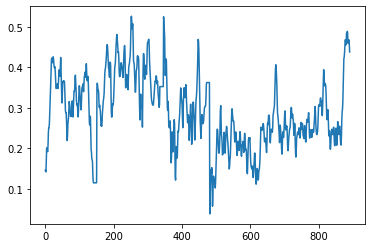

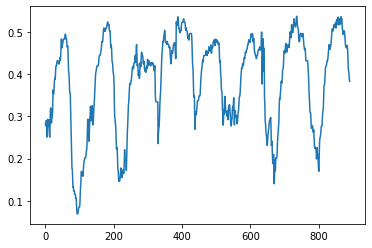

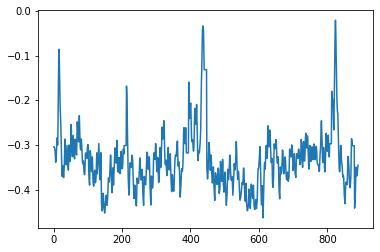

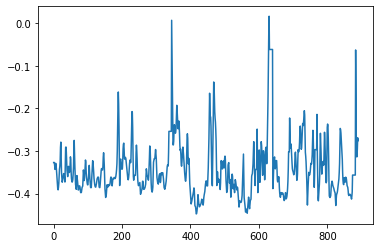

In [3]:
plt.figure()
plt.plot(range(heart_data.shape[1]), heart_data[0, :])
plt.figure()
plt.plot(range(heart_data.shape[1]), heart_data[1, :])
plt.figure()
plt.plot(range(heart_data.shape[1]), heart_data[2, :])
plt.figure()
plt.plot(range(heart_data.shape[1]), heart_data[3, :])

In [4]:
class RSPCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        inp_size = input_size + hidden_size
        self.sigm_lin = nn.Linear(inp_size, hidden_size)
        self.w_minus_lin = nn.Linear(inp_size, hidden_size)
        self.w_plus_lin = nn.Linear(inp_size, hidden_size)
    
    def forward(self, inp, hidden):
        inp = torch.cat((inp, hidden), dim=1)
        z = torch.sigmoid(self.sigm_lin(inp))
        q = self.w_minus_lin(inp)
        h_cand = self.w_plus_lin(inp)
        return (1 - z) * q + z * h_cand

In [5]:
np.random.seed(4)

T = 20
L = 1000
N = 100

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float64')
torch.save(data, open('traindata.pt', 'wb'))

In [6]:
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2021, 1, 27)

f = web.DataReader('^DJI', 'stooq', start, end)
ts = np.flip(f['Open'].values, axis=0).copy()
ts = ts / (ts.max() - ts.min())
ts = ts - ts.mean()

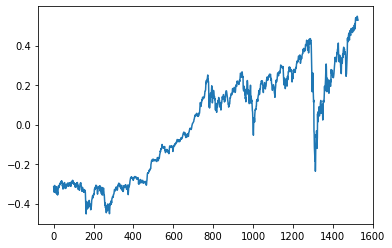

In [7]:
plt.figure()
plt.plot(range(len(ts)), ts)
plt.show()

In [8]:
print(type(ts))
print(ts.shape)
print(ts.strides)

<class 'numpy.ndarray'>
(1528,)
(8,)


STEP:  0
loss: 0.3873738646507263
loss: 0.35685813426971436
loss: 0.2907714545726776
loss: 0.23015713691711426
loss: 0.1770401895046234
loss: 0.1327996850013733
loss: 0.0979817733168602
loss: 0.07208919525146484
loss: 0.05355968698859215
loss: 0.040416885167360306
loss: 0.03095078282058239
loss: 0.023951774463057518
loss: 0.01864306814968586
loss: 0.014543738216161728
loss: 0.01135667972266674
loss: 0.008891223929822445
loss: 0.007010752335190773
loss: 0.005599829833954573
loss: 0.0045525566674768925
loss: 0.0037778220139443874
test loss: 0.005735555663704872


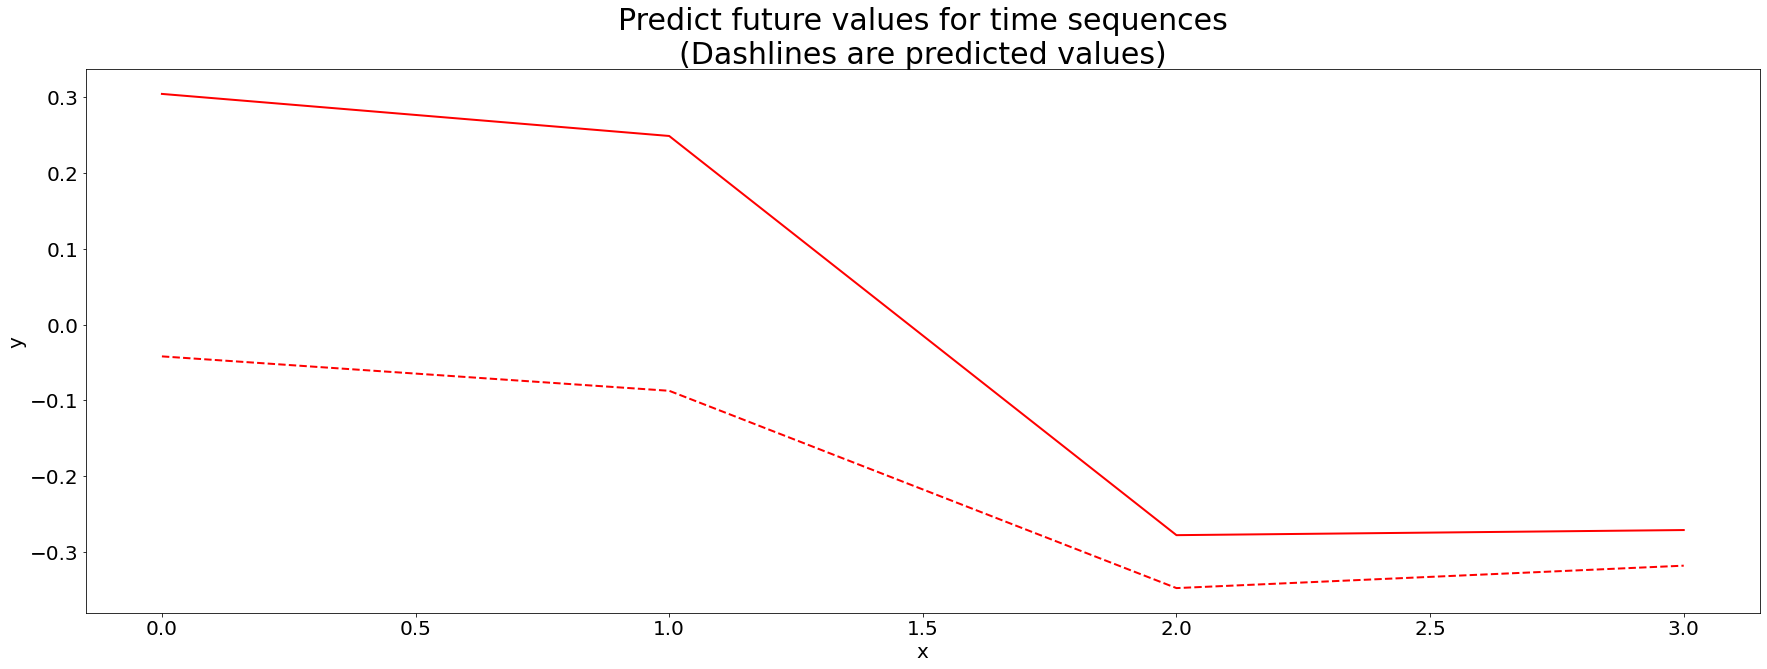

STEP:  1
loss: 0.003204357111826539
loss: 0.002778848400339484
loss: 0.0024620427284389734
loss: 0.0022252018097788095
loss: 0.0020473396871238947
loss: 0.0019131172448396683
loss: 0.001811302499845624
loss: 0.0017336452146992087
loss: 0.001674058847129345
loss: 0.001628040219657123
loss: 0.0015922387829050422
loss: 0.0015641552163287997
loss: 0.0015419129049405456
loss: 0.00152410042937845
loss: 0.0015096493298187852
loss: 0.0014977469108998775
loss: 0.0014877705834805965
loss: 0.0014792411820963025
loss: 0.001471785013563931
loss: 0.0014651053352281451
test loss: 0.003205762943252921


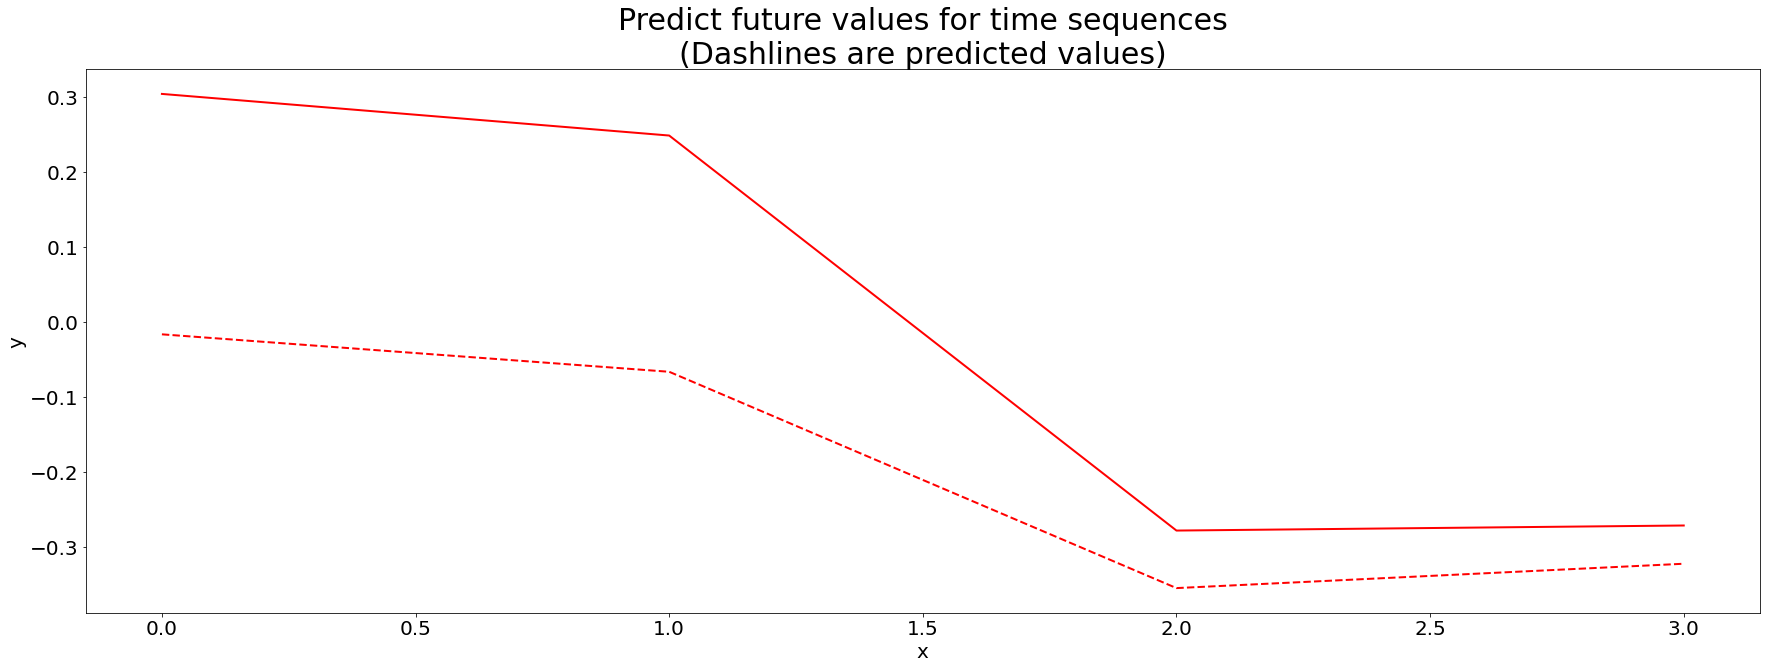

STEP:  2
loss: 0.0014589638449251652
loss: 0.001453162170946598
loss: 0.0014475308125838637
loss: 0.0014419200597330928
loss: 0.0014361912617459893
loss: 0.0014302133349701762
loss: 0.0014238590374588966
loss: 0.0014170046197250485
loss: 0.0014095299411565065
loss: 0.0014013212639838457
loss: 0.0013922713696956635
loss: 0.0013822783948853612
loss: 0.0013712390791624784
loss: 0.0013590347953140736
loss: 0.0013455057051032782
loss: 0.0013304142048582435
loss: 0.0013133882312104106
loss: 0.0012938248692080379
loss: 0.001270697801373899
loss: 0.0012421341380104423
test loss: 0.0022004360798746347


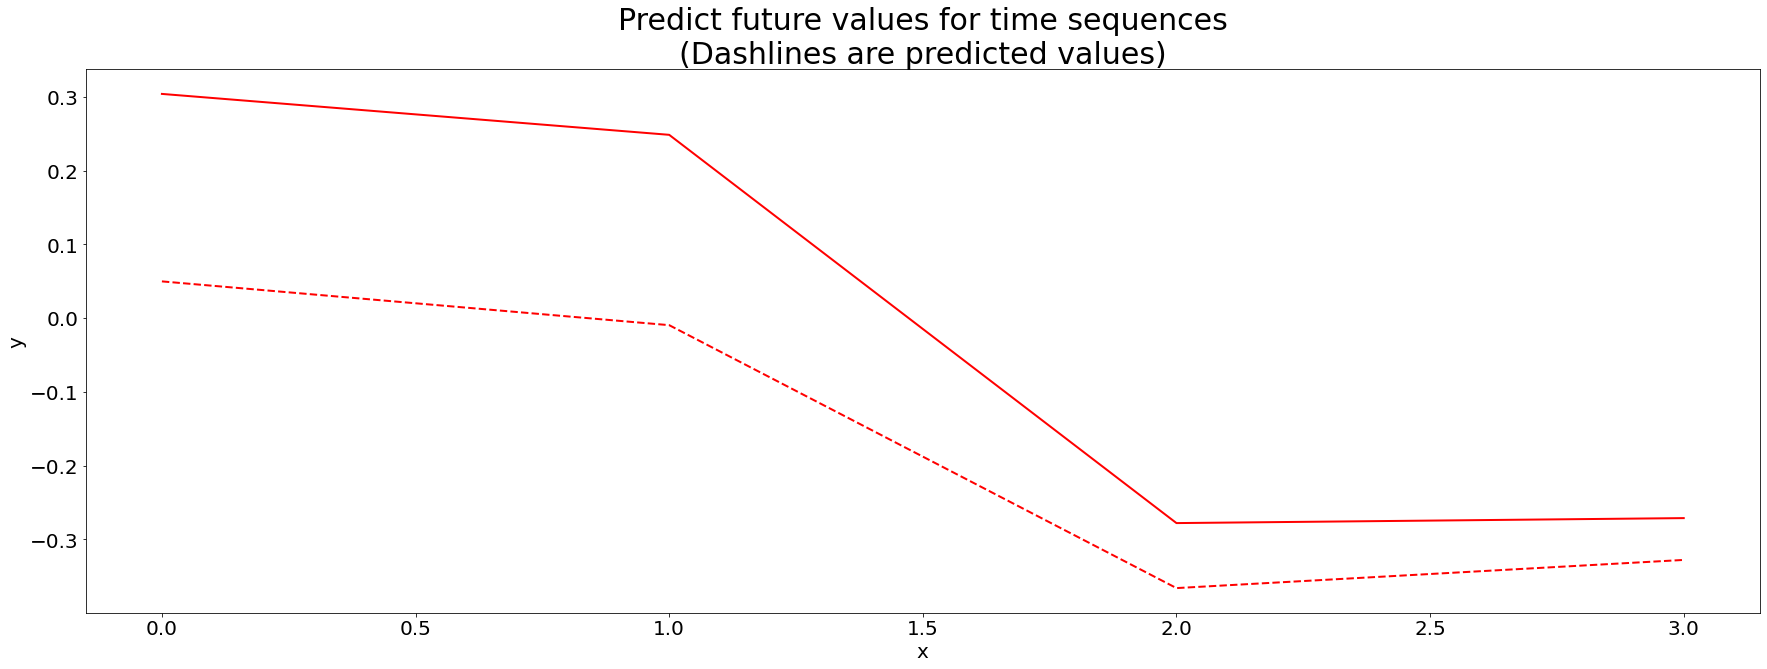

STEP:  3
loss: 0.001204043859615922
loss: 0.0011472642654553056
loss: 0.0010319548891857266
loss: 0.0008875807397998869
loss: 0.0007934322929941118
loss: 0.00077550153946504
loss: 0.000766897399444133
loss: 0.0007602761033922434
loss: 0.000754656211938709
loss: 0.0007496462785638869
loss: 0.0007449687691405416
loss: 0.0007403792697004974
loss: 0.0007356064161285758
loss: 0.0007302536396309733
loss: 0.0007235474186018109
loss: 0.0007141103269532323
loss: 0.0007018643082119524
loss: 0.0006883853347972035
loss: 0.0006730831228196621
loss: 0.0006591688725166023
test loss: 0.0008831354207359254


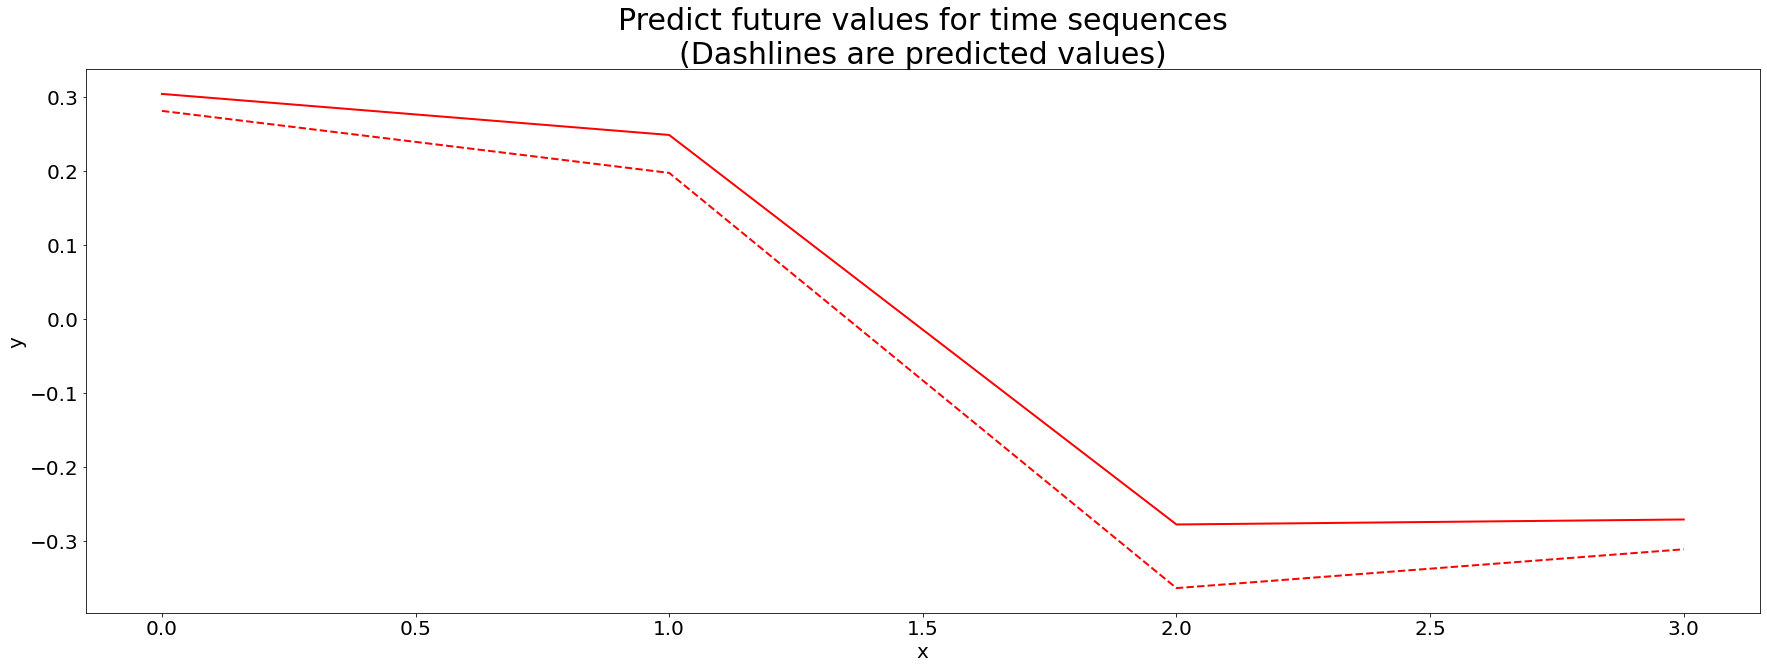

STEP:  4
loss: 0.0006454687099903822
loss: 0.0006322585977613926
loss: 0.0006196862086653709
loss: 0.0006080148741602898
loss: 0.0005969866761006415
loss: 0.000585415109526366
loss: 0.0005732880090363324
loss: 0.0005622525350190699
loss: 0.0005521506536751986
loss: 0.0005423893453553319
loss: 0.0005337581969797611
loss: 0.0005254181451164186
loss: 0.0005176130216568708
loss: 0.0005091800703667104
loss: 0.0005011340253986418
loss: 0.000494040665216744
loss: 0.0004870385746471584
loss: 0.0004804183845408261
loss: 0.00047431507846340537
loss: 0.0004690999339800328
test loss: 0.0007701943977735937


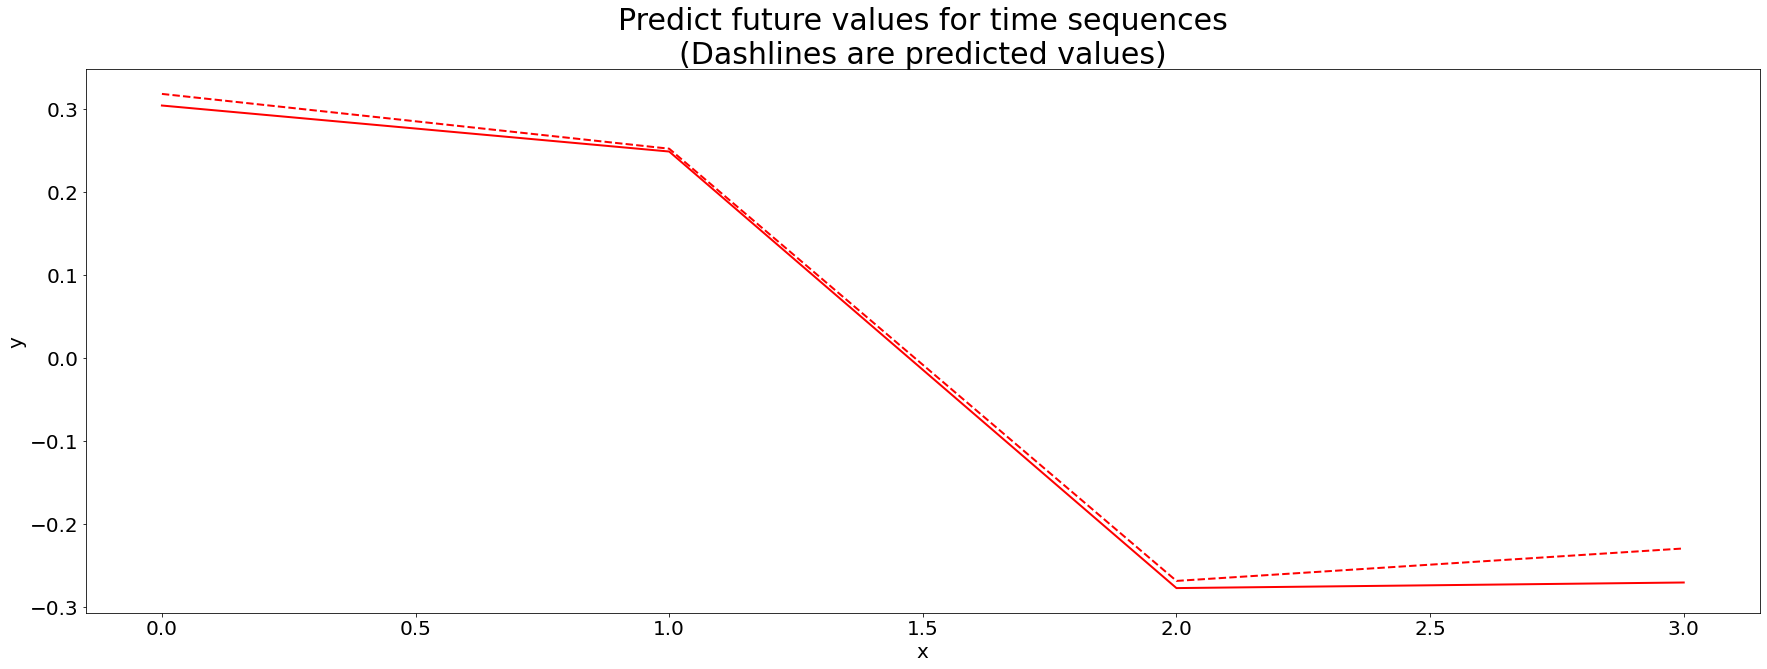

STEP:  5
loss: 0.0004646503657568246
loss: 0.0004608496092259884
loss: 0.0004575895145535469
loss: 0.0004550111189018935
loss: 0.00045286386739462614
loss: 0.00045118428533896804
loss: 0.0004497812478803098
loss: 0.00044867198448628187
loss: 0.00044775157584808767
loss: 0.0004470122221391648
loss: 0.0004463893419597298
loss: 0.0004458763578440994
loss: 0.0004454389854799956
loss: 0.0004450654669199139
loss: 0.0004447366518434137
loss: 0.0004444431106094271
loss: 0.0004441817873157561
loss: 0.00044394307769834995
loss: 0.00044373018317855895
loss: 0.000443537108367309
test loss: 0.0006999794277362525


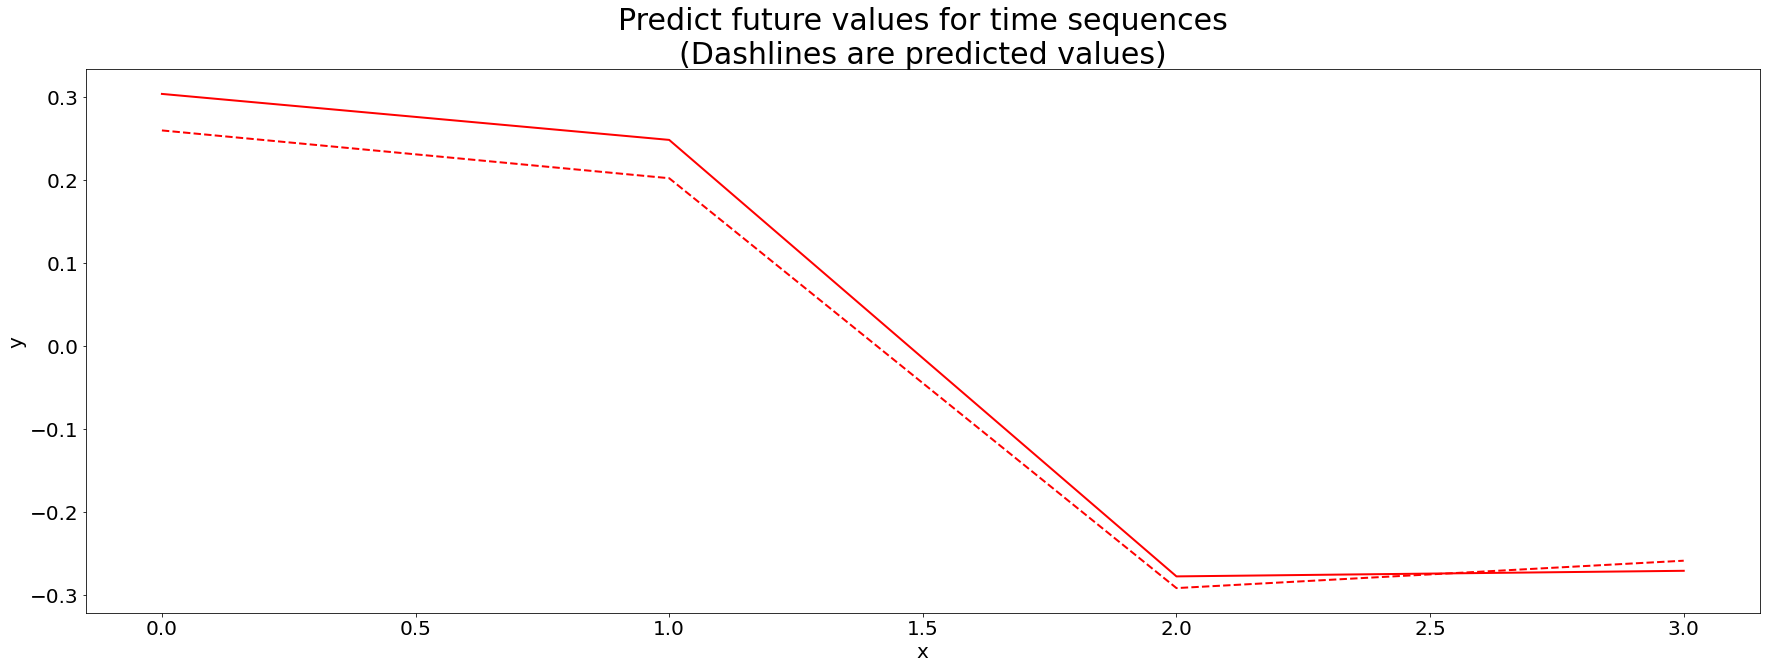

STEP:  6
loss: 0.0004433616413734853
loss: 0.0004431981360539794
loss: 0.00044304653420113027
loss: 0.00044290319783613086
loss: 0.0004427671665325761
loss: 0.0004426355008035898
loss: 0.00044250741484574974
loss: 0.0004423802893143147
loss: 0.000442253309302032
loss: 0.0004421229241415858
loss: 0.0004419885517563671
loss: 0.0004418435273692012
loss: 0.00044168750173412263
loss: 0.00044150077155791223
loss: 0.0004412857524584979
loss: 0.00044102210085839033
loss: 0.000440731062553823
loss: 0.00044044273090548813
loss: 0.0004401746264193207
loss: 0.0004399308527354151
test loss: 0.000690631044562906


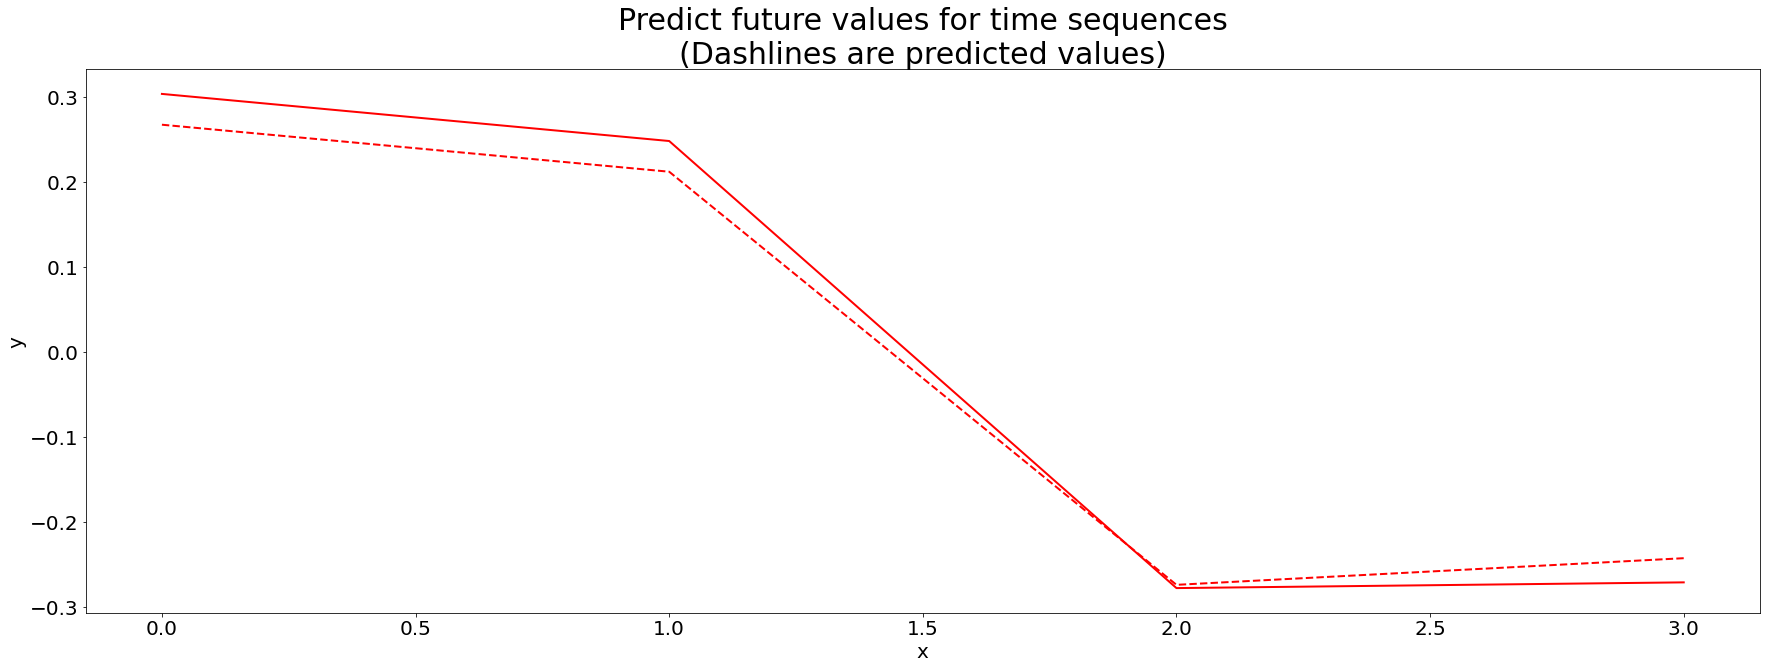

STEP:  7
loss: 0.00043972497223876417
loss: 0.00043954321881756186
loss: 0.00043939633178524673
loss: 0.0004392621049191803
loss: 0.0004391510447021574
loss: 0.00043905293568968773
loss: 0.000438969349488616
loss: 0.0004388828238006681
loss: 0.0004388140223454684
loss: 0.00043874396942555904
loss: 0.0004386766813695431
loss: 0.00043860345613211393
loss: 0.0004385293577797711
loss: 0.00043845336767844856
loss: 0.0004383766499813646
loss: 0.000438293325714767
loss: 0.0004382064798846841
loss: 0.0004381135222502053
loss: 0.00043801753781735897
loss: 0.000437921000411734
test loss: 0.0006945448694750667


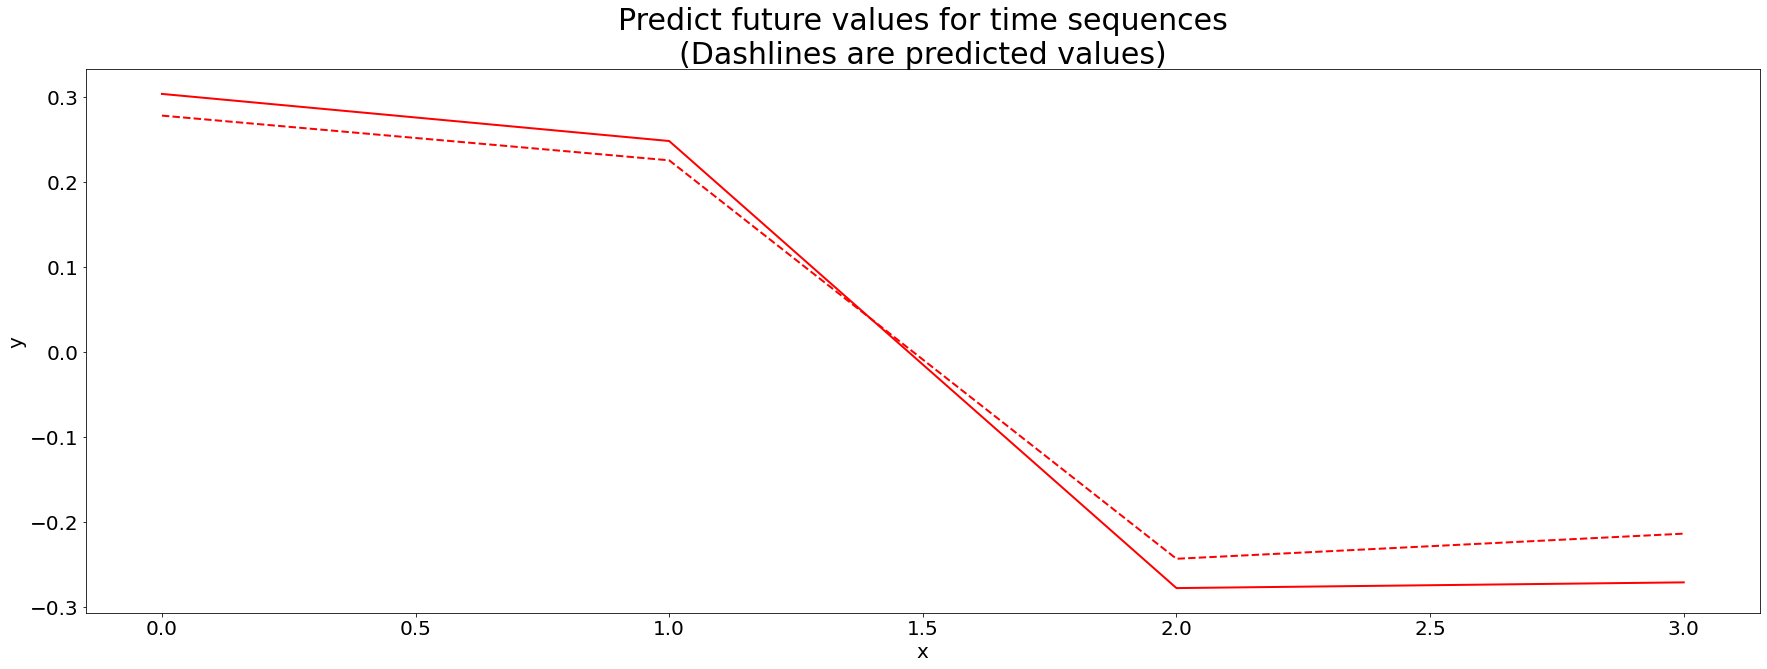

STEP:  8
loss: 0.0004378137819003314
loss: 0.00043772472417913377
loss: 0.0004376372671686113
loss: 0.0004375512362457812
loss: 0.00043747067684307694
loss: 0.00043739649117924273
loss: 0.0004373315896373242
loss: 0.0004372760886326432
loss: 0.0004372303665149957
loss: 0.00043719253153540194
loss: 0.0004371618269942701
loss: 0.00043713703053072095
loss: 0.0004371168033685535
loss: 0.0004371004179120064
loss: 0.0004370868264231831
loss: 0.00043707556324079633
loss: 0.00043706607539206743
loss: 0.00043705795542337
loss: 0.00043705079588107765
loss: 0.0004370444512460381
test loss: 0.0006912604440003633


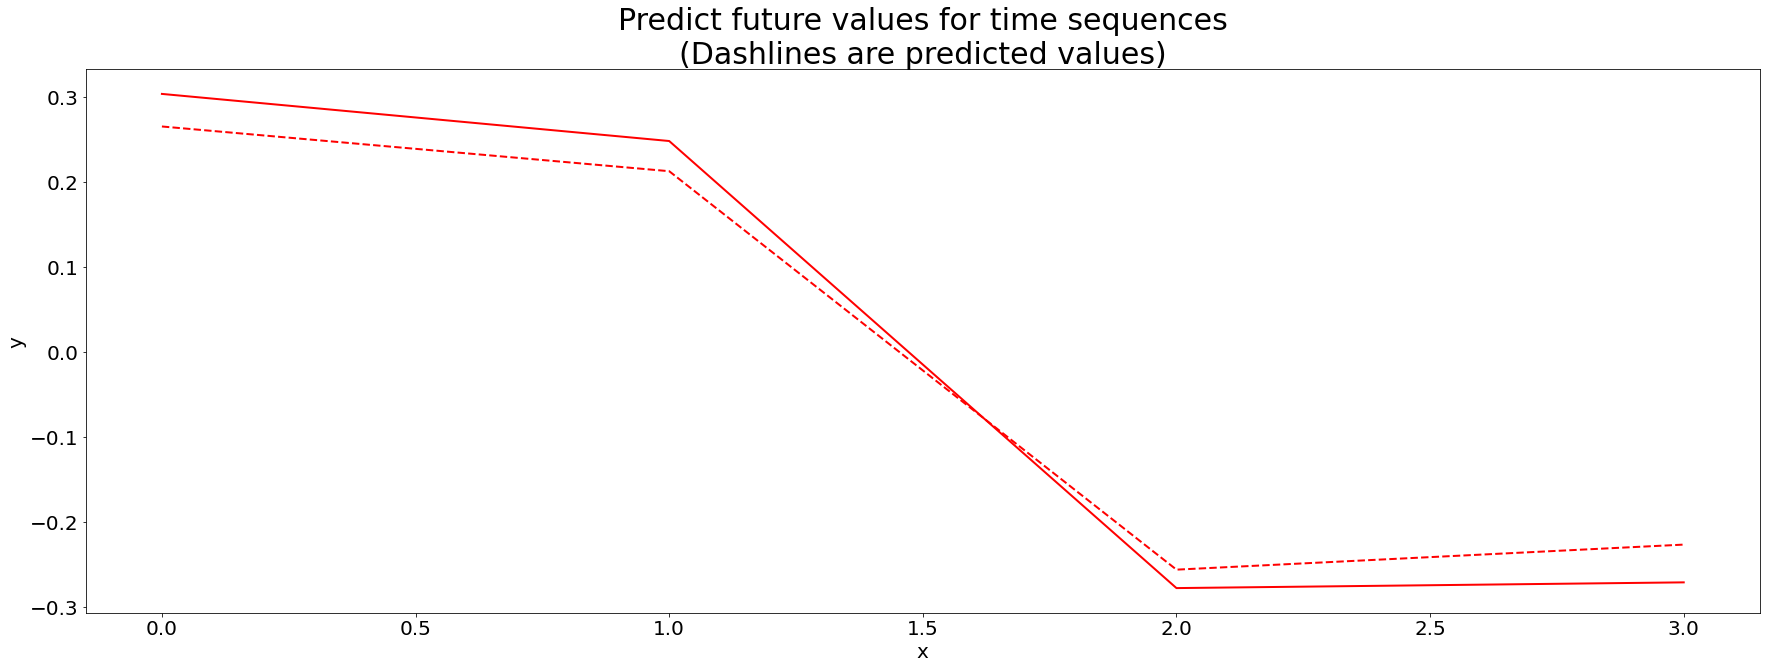

STEP:  9
loss: 0.00043703848496079445
loss: 0.0004370329261291772
loss: 0.00043702736729756
loss: 0.00043702186667360365
loss: 0.0004370161914266646
loss: 0.0004370099923107773
loss: 0.0004370028036646545
loss: 0.00043699334491975605
loss: 0.0004369768430478871
loss: 0.0004369585949461907
loss: 0.00043693394400179386
loss: 0.00043690434540621936
loss: 0.0004368725058156997
loss: 0.0004368425870779902
loss: 0.0004368145891930908
loss: 0.000436786183854565
loss: 0.0004367553920019418
loss: 0.0004367212241049856
loss: 0.000436682952567935
loss: 0.00043664066470228136
test loss: 0.0006843804731033742


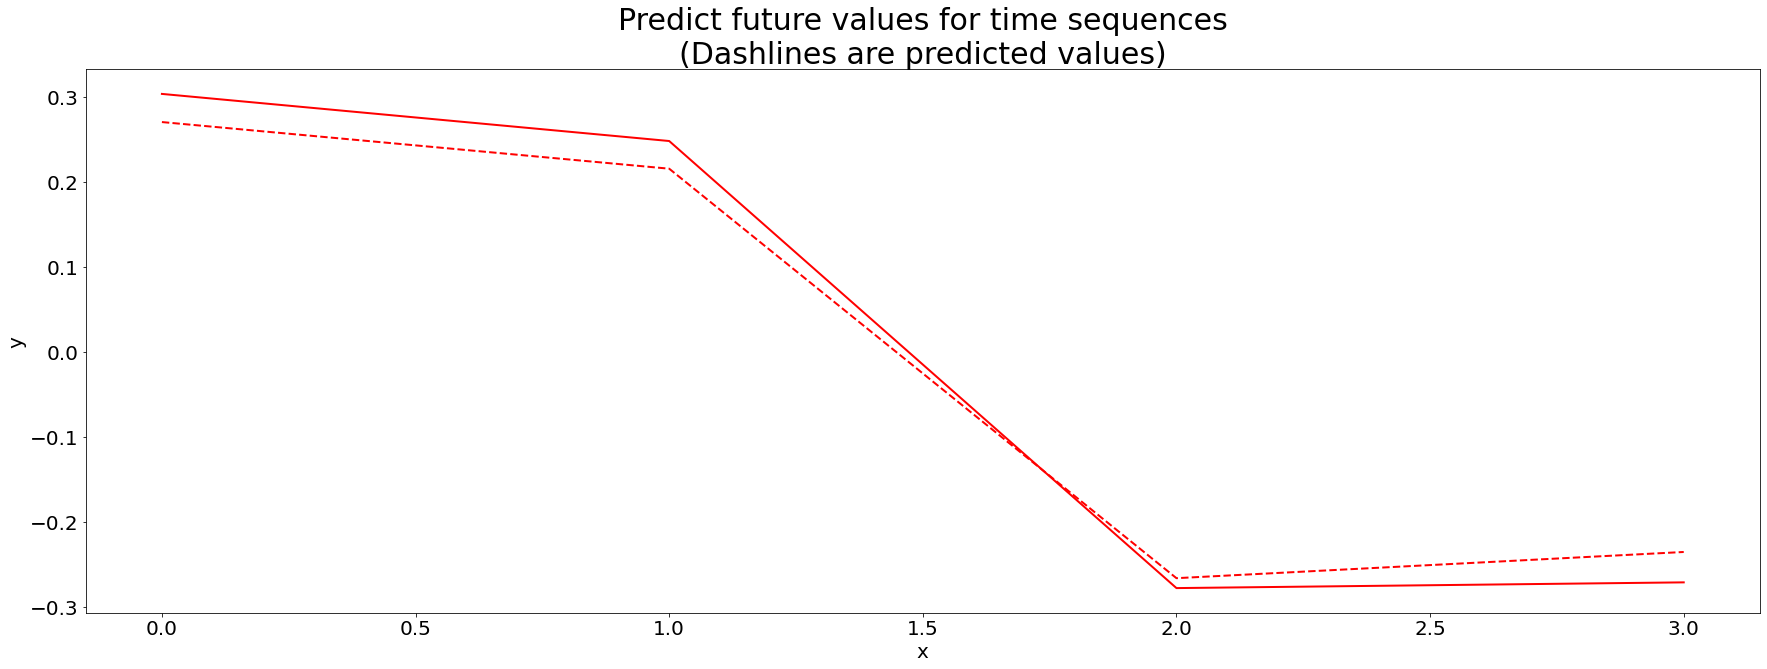

STEP:  10
loss: 0.00043659386574290693
loss: 0.000436539005022496
loss: 0.0004364765773061663
loss: 0.0004363998887129128
loss: 0.000436310627264902
loss: 0.00043624945101328194
loss: 0.0004361980827525258
loss: 0.0004361504688858986
loss: 0.0004361066094134003
loss: 0.0004360659804660827
loss: 0.0004360294551588595
loss: 0.0004359999147709459
loss: 0.0004359768645372242
loss: 0.0004359570157248527
loss: 0.00043593946611508727
loss: 0.0004359227605164051
loss: 0.000435906695201993
loss: 0.0004358924925327301
loss: 0.0004358796286396682
loss: 0.0004358685982879251
test loss: 0.0006750409957021475


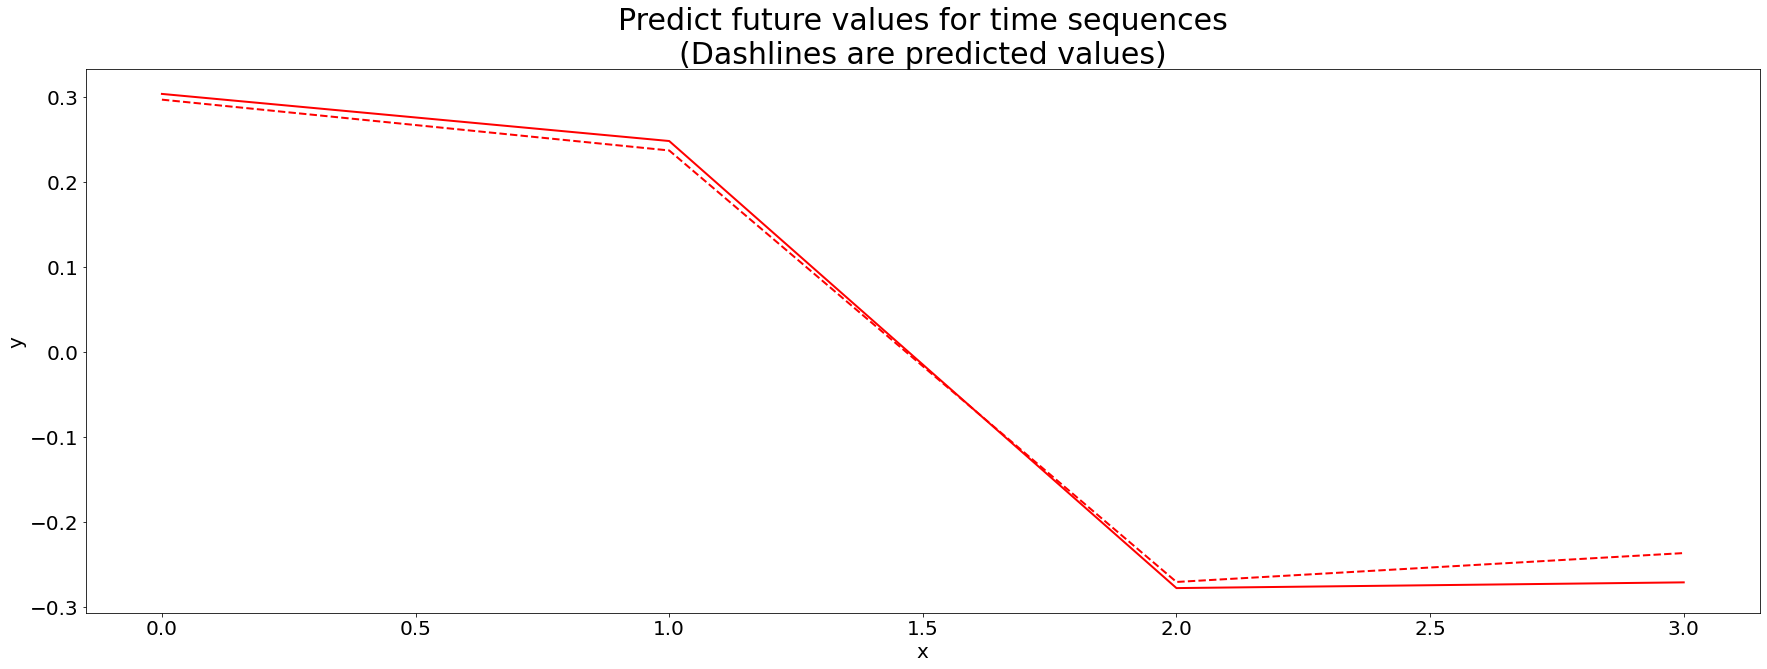

STEP:  11
loss: 0.0004358590522315353
loss: 0.00043585075763985515
loss: 0.0004358437145128846
loss: 0.0004358373989816755
loss: 0.00043583218939602375
loss: 0.00043582773650996387
loss: 0.00043582424405030906
loss: 0.0004358211881481111
loss: 0.00043581874342635274
loss: 0.0004358165606390685
loss: 0.00043581449426710606
loss: 0.00043581106001511216
loss: 0.0004358090227469802
loss: 0.0004358061996754259
loss: 0.0004358002624940127
loss: 0.0004357912403065711
loss: 0.0004357740399427712
loss: 0.0004357467405498028
loss: 0.0004357137659098953
loss: 0.00043567310785874724
test loss: 0.0006760495598427951


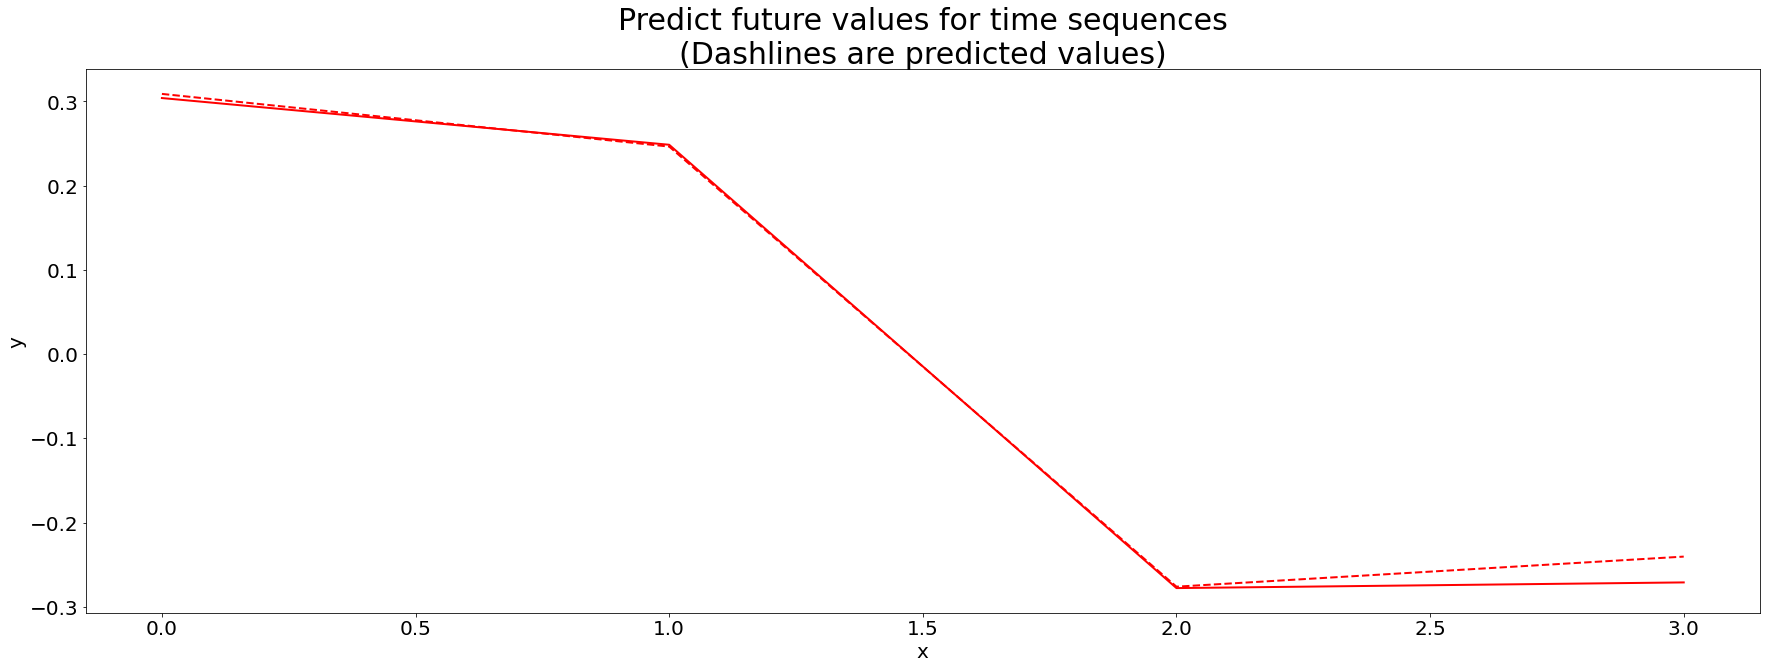

STEP:  12
loss: 0.00043562924838624895
loss: 0.0004355774144642055
loss: 0.0004355194978415966
loss: 0.000435448921052739
loss: 0.00043536792509257793
loss: 0.00043526050285436213
loss: 0.0004351495881564915
loss: 0.0004350690287537873
loss: 0.0004349911177996546
loss: 0.00043491023825481534
loss: 0.0004348346556071192
loss: 0.0004347447247710079
loss: 0.0004346885543782264
loss: 0.00043464676127769053
loss: 0.00043459812877699733
loss: 0.00043453756370581686
loss: 0.00043446157360449433
loss: 0.00043437728891149163
loss: 0.00043427557102404535
loss: 0.00043416814878582954
test loss: 0.0006838489789515734


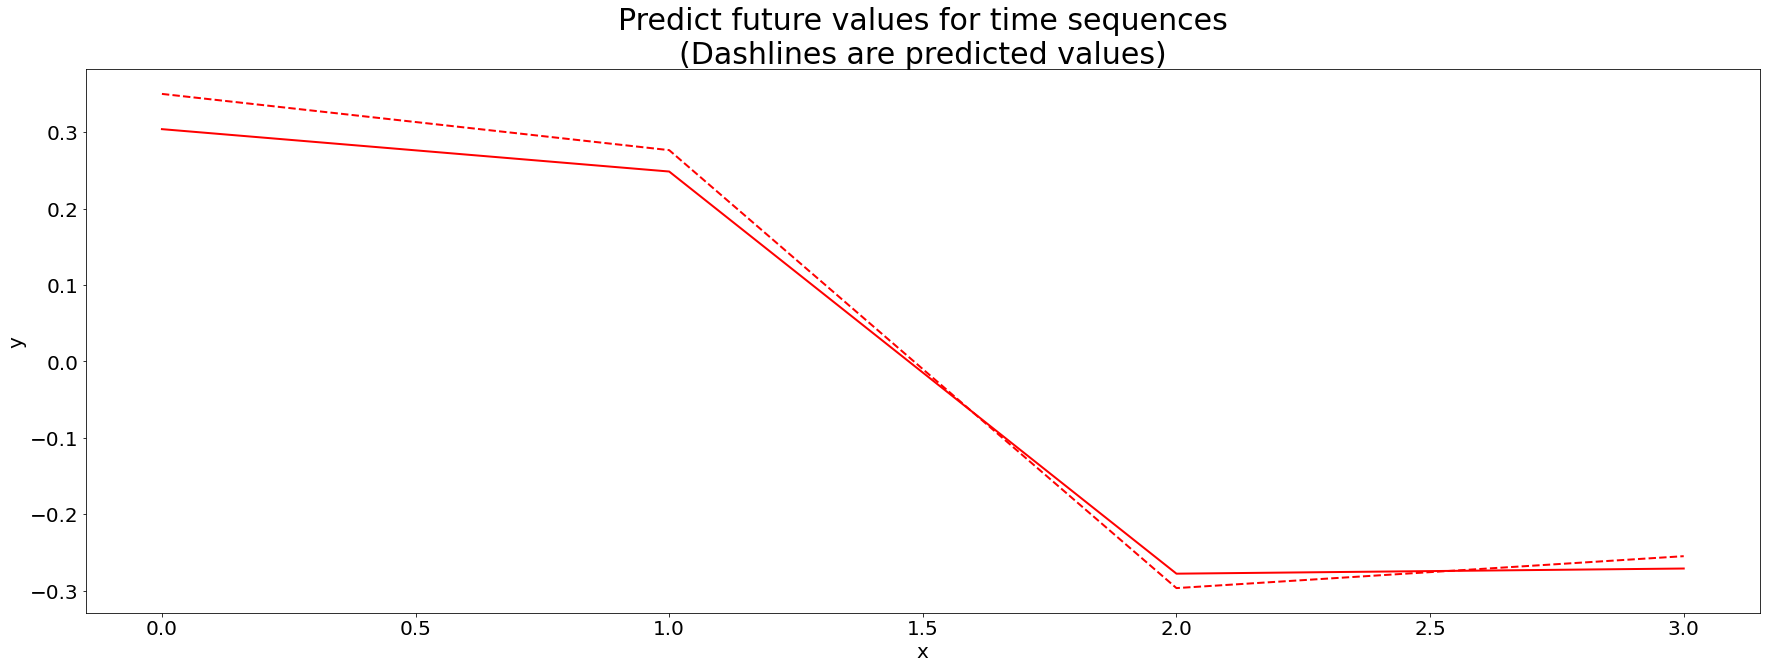

STEP:  13
loss: 0.0004340512095950544
loss: 0.0004339400038588792
loss: 0.0004338313592597842
loss: 0.00043372242362238467
loss: 0.00043360565905459225
loss: 0.00043353717774152756
loss: 0.0004334815312176943
loss: 0.00043342282879166305
loss: 0.00043336700764484704
loss: 0.00043330833432264626
loss: 0.00043324995203875005
loss: 0.00043318094685673714
loss: 0.00043310641194693744
loss: 0.00043301357072778046
loss: 0.0004329174989834428
loss: 0.00043280405225232244
loss: 0.0004327040514908731
loss: 0.00043258059304207563
loss: 0.00043248271686024964
loss: 0.00043237642967142165
test loss: 0.0006758630042895675


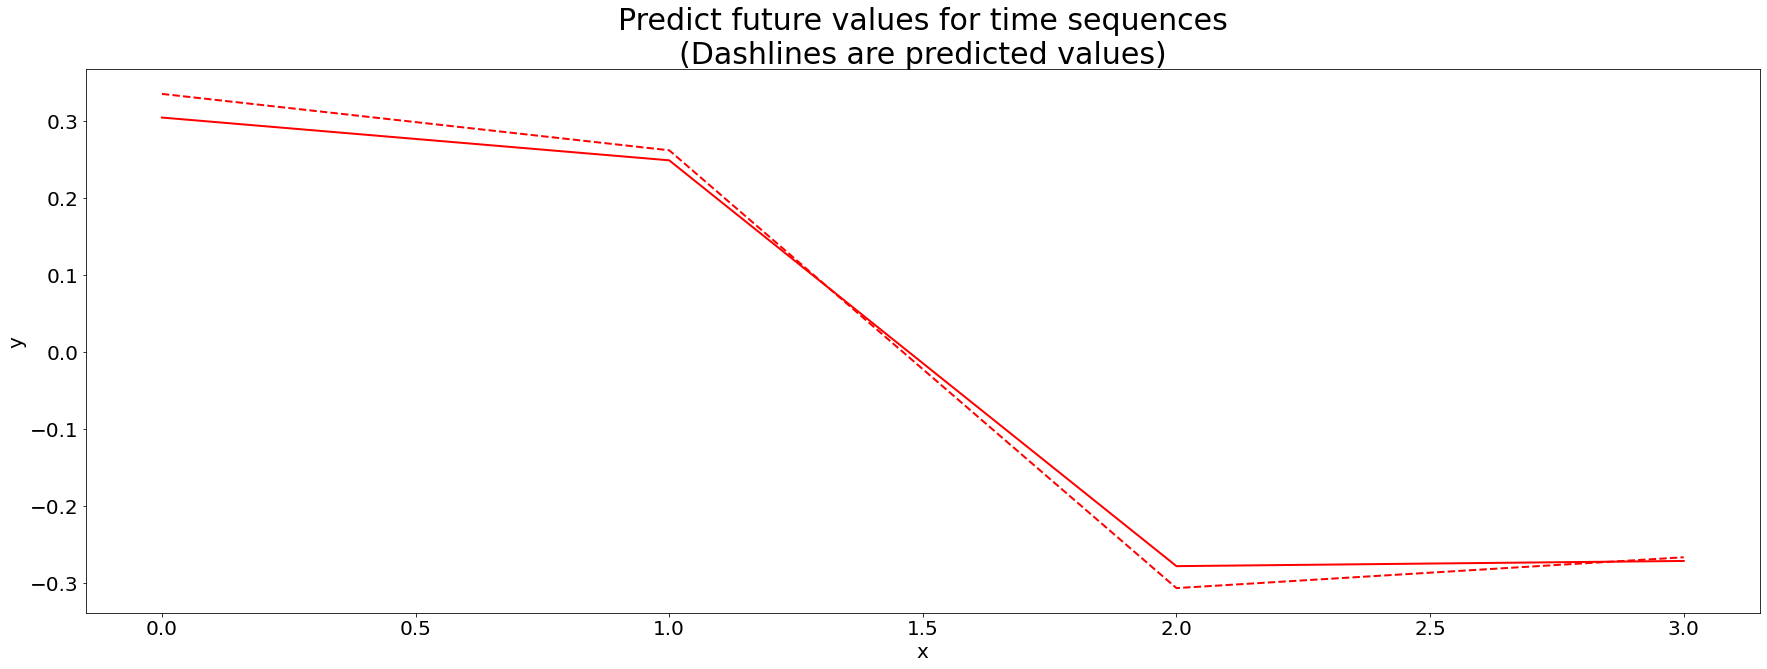

STEP:  14
loss: 0.00043230029405094683
loss: 0.00043222535168752074
loss: 0.00043215896585024893
loss: 0.00043210736475884914
loss: 0.0004320567531976849
loss: 0.000432012602686882
loss: 0.0004319711879361421
loss: 0.00043193838791921735
loss: 0.0004319094296079129
loss: 0.0004318844003137201
loss: 0.00043186210677959025
loss: 0.0004318436258472502
loss: 0.00043182726949453354
loss: 0.00043181260116398335
loss: 0.0004317990969866514
loss: 0.00043178649502806365
loss: 0.00043177418410778046
loss: 0.00043176196049898863
loss: 0.0004317490092944354
loss: 0.0004317349521443248
test loss: 0.0006813532090745866


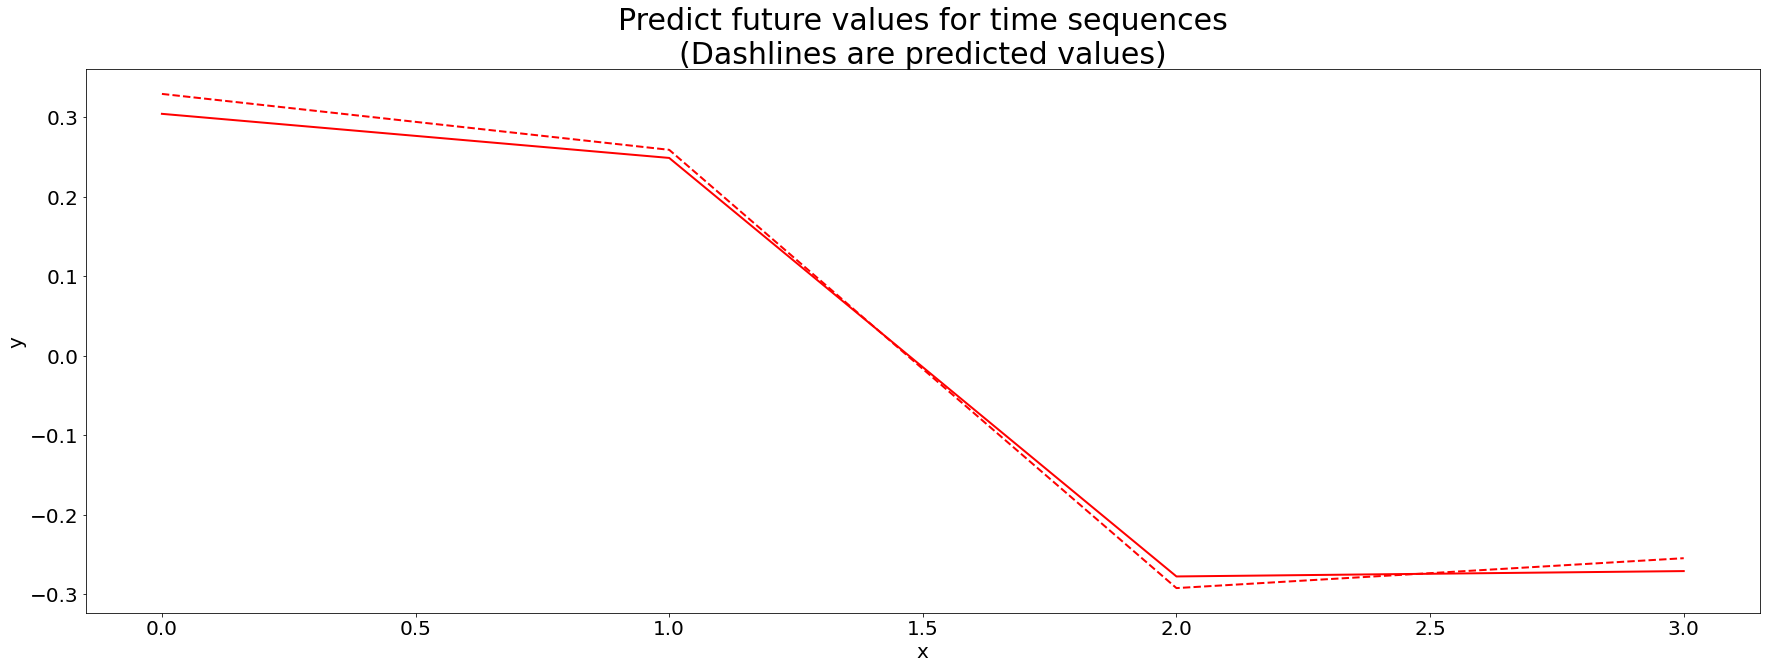

STEP:  15
loss: 0.0004317190614528954
loss: 0.000431693420978263
loss: 0.00043166239629499614
loss: 0.0004316344566177577
loss: 0.0004316070699132979
loss: 0.00043158052721992135
loss: 0.00043155471212230623
loss: 0.00043152892612852156
loss: 0.0004315042169764638
loss: 0.0004314799152780324
loss: 0.00043145602103322744
loss: 0.0004314313700888306
loss: 0.000431405525887385
loss: 0.0004313774697948247
loss: 0.00043134784209541976
loss: 0.0004313165263738483
loss: 0.0004312856763135642
loss: 0.00043125261436216533
loss: 0.0004312222881708294
loss: 0.00043119059409946203
test loss: 0.0006804928998462856


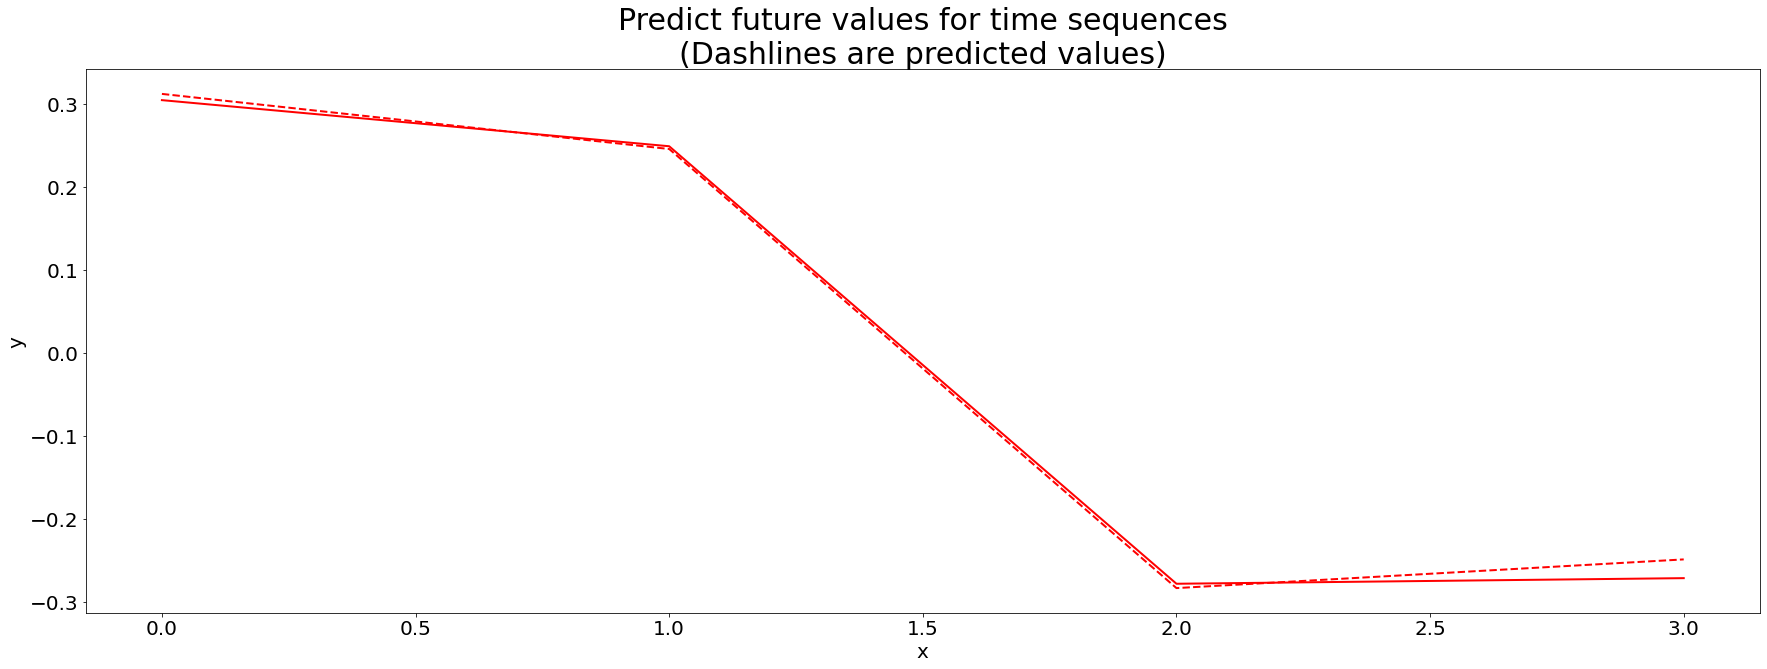

STEP:  16
loss: 0.00043116320739500225
loss: 0.00043113442370668054
loss: 0.0004311091033741832
loss: 0.0004310798249207437
loss: 0.000431053398642689
loss: 0.0004310336080379784
loss: 0.00043101233313791454
loss: 0.00043099530739709735
loss: 0.00043097761226817966
loss: 0.00043095971341244876
loss: 0.0004309384385123849
loss: 0.00043091425322927535
loss: 0.000430882879300043
loss: 0.00043084940989501774
loss: 0.0004308084899093956
loss: 0.00043076809379272163
loss: 0.0004307206254452467
loss: 0.00043067545630037785
loss: 0.0004306224873289466
loss: 0.00043056884896941483
test loss: 0.0006845839088782668


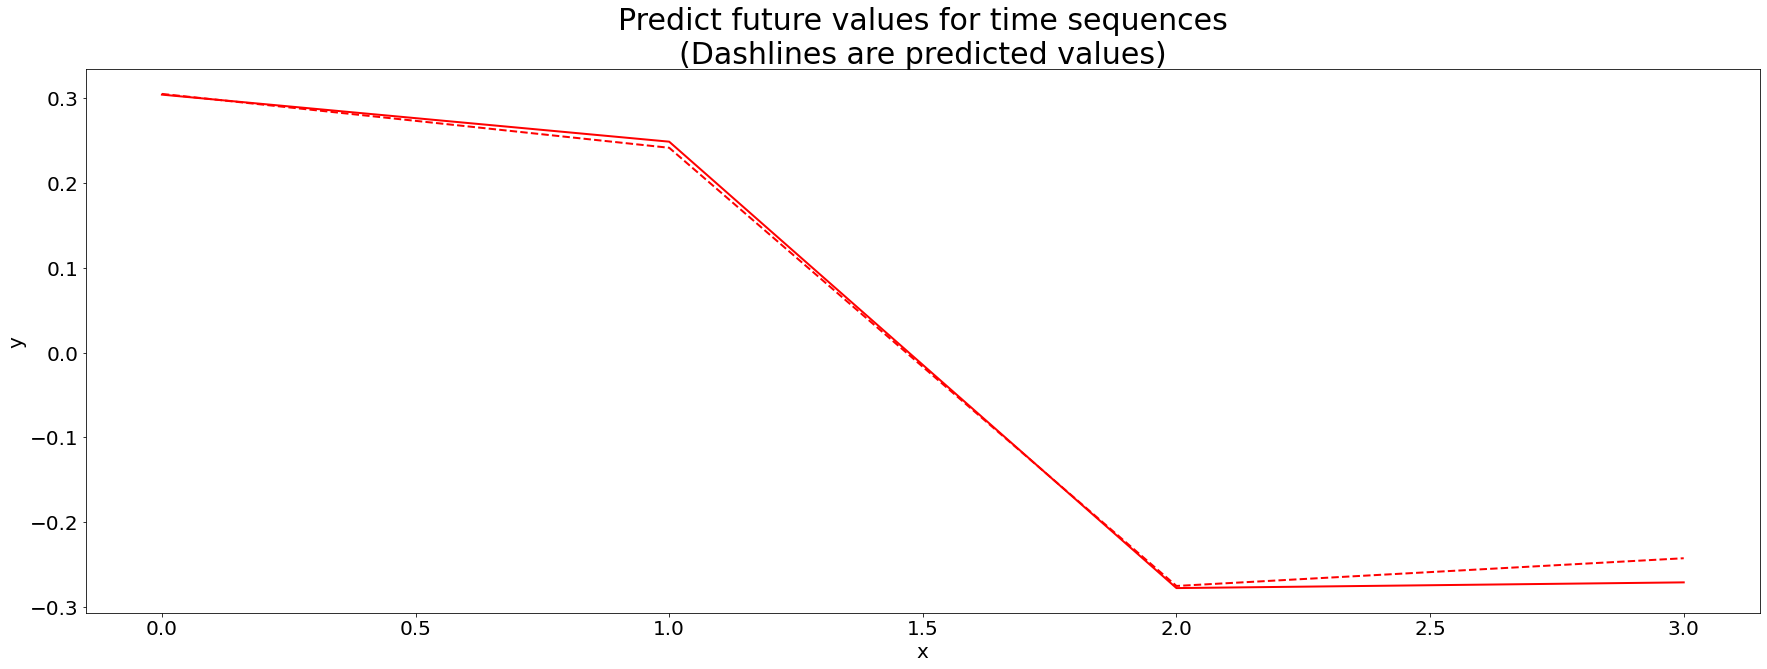

STEP:  17
loss: 0.0004305071197450161
loss: 0.0004304425383452326
loss: 0.00043037073919549584
loss: 0.00043028980144299567
loss: 0.0004302293236833066
loss: 0.00043017693678848445
loss: 0.0004301279259379953
loss: 0.0004300743748899549
loss: 0.00043001744779758155
loss: 0.0004299583670217544
loss: 0.0004299004503991455
loss: 0.0004298447456676513
loss: 0.0004297905834391713
loss: 0.00042973627569153905
loss: 0.00042968671186827123
loss: 0.0004296389233786613
loss: 0.0004295976832509041
loss: 0.00042955970275215805
loss: 0.00042952681542374194
loss: 0.00042949517956003547
test loss: 0.0006938892765901983


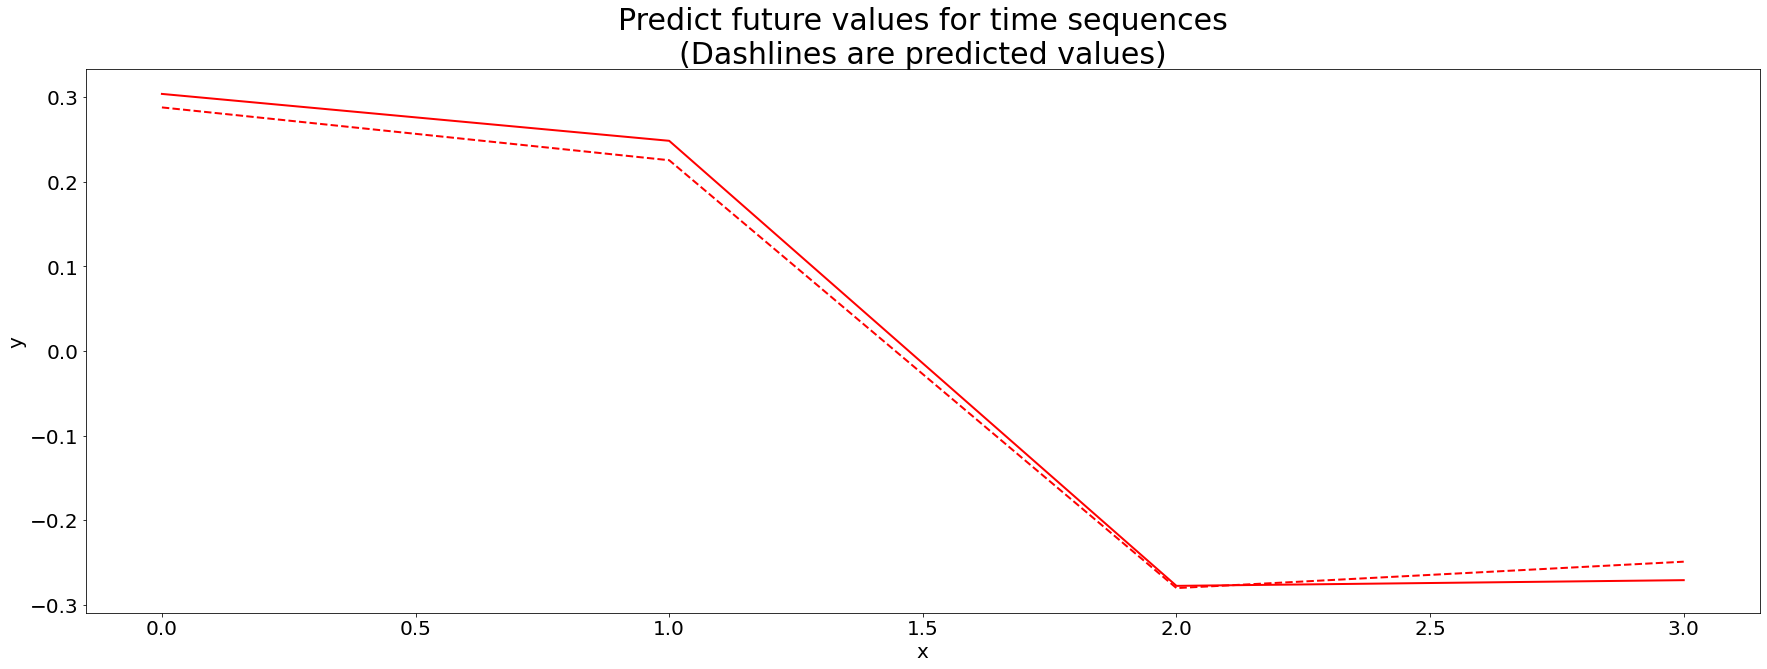

Elapsed time: 120.892605129 seconds.


In [79]:
DEVICE = 'cpu'
CELL = nn.GRUCell
NUM_CELLS = 1

def recurrent_cells_forward(cells, inp, contexts):
    for i, cell in enumerate(cells):
        inp = cell(inp, contexts[i])
        contexts[i] = inp
    return inp

def get_pos_emb(ts, freqs):
    return torch.tensor([np.sin(f * ts) for f in freqs]).to(DEVICE)

class Sequence(nn.Module):
    def __init__(self, input_size, hidden_size, embedding_frequencies=()):
        super(Sequence, self).__init__()
        recurrent_cells = []
        self.embedding_frequencies = embedding_frequencies
        input_size = input_size + len(embedding_frequencies)
        for i in range(NUM_CELLS):
            if i == 0:
                recurrent_cells.append(CELL(input_size, hidden_size))
            else:
                recurrent_cells.append(CELL(hidden_size, hidden_size))
        self.recurrent_cells = nn.ModuleList(recurrent_cells)
        #self.lstm1 = CELL(input_size, hidden_size)#RSPCell(input_size, hidden_size)
        #self.lstm2 = nn.LSTMCell(32, 32)
        self.linear = nn.Linear(hidden_size, 1)
        self.hidden_size = hidden_size

    def forward(self, inp, future = 0, first_ts = 0):
        outputs = []
        contexts = []
        B = inp.size(0)
        for i in range(NUM_CELLS):
            contexts.append(torch.zeros(B, self.hidden_size, dtype=torch.double, device=DEVICE))
        #c_t = torch.zeros(input.size(0), 32, dtype=torch.double)
        #h_t2 = torch.zeros(input.size(0), 32, dtype=torch.double)
        #c_t2 = torch.zeros(input.size(0), 32, dtype=torch.double)

        for i, input_t in enumerate(inp.split(1, dim=1)):
            #import pdb;pdb.set_trace()
            input_t = input_t.squeeze(dim=1)
            if len(self.embedding_frequencies) > 0:
                ts = first_ts + i
                pos_emb = get_pos_emb(ts, self.embedding_frequencies).unsqueeze(0).repeat(B, 1)
                input_t = torch.cat((input_t, pos_emb), dim=1)
            final_context = recurrent_cells_forward(self.recurrent_cells, input_t.squeeze(dim=1), contexts)
            #h_t = self.lstm1(input_t.squeeze(dim=1), h_t)#(h_t, c_t))
            #h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            #output = self.linear(h_t)#2)
            output = self.linear(final_context)
            outputs += [output]
        future_input = outputs[-INP_SIZE:]
        for i in range(future):# if we should predict the future
            input_t = torch.cat(future_input, dim=1)
            if len(self.embedding_frequencies) > 0:
                ts = first_ts + inp.size(1) + i
                pos_emb = get_pos_emb(ts, self.embedding_frequencies).unsqueeze(0).repeat(B, 1)
                input_t = torch.cat((input_t, pos_emb), dim=1)            
            final_context = recurrent_cells_forward(self.recurrent_cells, input_t, contexts)
            #h_t = self.lstm1(inp, h_t)#(h_t, c_t))
            #h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            #output = self.linear(h_t)#2)
            output = self.linear(final_context)
            outputs += [output]
            future_input.pop(0)
            future_input.append(output)
        outputs = torch.cat(outputs, dim=1)
        return outputs


class LinearPredictor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.predictor = nn.Linear(input_size, 1)
    
    def forward(self, inp, future=0):
        outputs = []
        #import pdb;pdb.set_trace()
        for input_t in inp.split(1, dim=1):
            output = self.predictor(input_t.squeeze(dim=1))
            outputs += [output]
        #import pdb;pdb.set_trace()
        future_input = outputs[-INP_SIZE:]
        for i in range(future):
            inp = torch.cat(future_input, dim=1)
            output = self.predictor(inp)
            outputs += [output]
            future_input.pop(0)
            future_input.append(output)
        outputs = torch.cat(outputs, dim=1)
        #import pdb;pdb.set_trace()
        return outputs

STEPS = 18
INP_SIZE = 2
HIDDEN_SIZE = 16
FUTURE = 30
LR = 0.12
MODEL = Sequence
EMB_FREQS = [np.pi / 2 ** i for i in range(1, 9)]

def sw(t: torch.Tensor) -> torch.Tensor:
    return t.unfold(dimension=1, size=INP_SIZE, step=1)

def get_train_test_data_sin():
    data = torch.load('traindata.pt')
    return (
        sw(torch.from_numpy(data[3:, :-1])).to(DEVICE),
        torch.from_numpy(data[3:, INP_SIZE:]).to(DEVICE),
        sw(torch.from_numpy(data[:3, :-1])).to(DEVICE),
        torch.from_numpy(data[:3, INP_SIZE:]).to(DEVICE),
    )


def get_train_test_data_from_ts(ts: np.ndarray, train_ratio=0.9):
    N = len(ts)
    train_size = int(N * train_ratio)
    test_size = N - train_size
    train_ts = ts[:train_size]
    test_ts = ts[train_size:]
    return (
        sw(torch.from_numpy(train_ts[:-1]).view(1, train_size - 1)).to(DEVICE),
        torch.from_numpy(train_ts[INP_SIZE:]).view(1, train_size - INP_SIZE).to(DEVICE),
        sw(torch.from_numpy(test_ts[:-1]).view(1, test_size - 1)).to(DEVICE),
        torch.from_numpy(test_ts[INP_SIZE:]).view(1, test_size - INP_SIZE).to(DEVICE)
    )


# set random seed to 0
np.random.seed(4)
torch.manual_seed(4)
# load data and make training set
data = torch.load('traindata.pt')

start = time.perf_counter_ns()

inp, target, test_input, test_target = get_train_test_data_heart_rate(heart_data)

#import pdb;pdb.set_trace()
# build the model
#seq = MODEL(INP_SIZE, HIDDEN_SIZE, EMB_FREQS).to(DEVICE).double()

cm = ContextsManager()
baseline = LinearForecaster(cm, INP_SIZE)
# INP_SIZE + 1 because correction block also takes baseline
# forecast as extra input
corrector = RSPForecaster(cm, INP_SIZE + 1, HIDDEN_SIZE)
model = RecurrentForecasterWithCorrectionBlock(cm, baseline, corrector)

criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(model.parameters(), lr=LR)
#begin to train
for i in range(STEPS):
    print('STEP: ', i)
    def closure():
        optimizer.zero_grad()
        out = run_on_inps_with_targets(model, inp, target, baseline_no_grad=False)
        loss = criterion(out, target)
        print('loss:', loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        pred = run_on_inps_with_targets(model, test_input, test_target, baseline_no_grad=True)
        loss = criterion(pred, test_target)
        print('test loss:', loss.item())
        y = pred.detach().cpu().numpy()
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    def draw(yi, targeti, color):
        plt.plot(np.arange(test_input.size(1)), yi[:test_input.size(1)], color + '--', linewidth = 2.0)
        plt.plot(np.arange(test_input.size(1)), targeti, color, linewidth = 2.0)
#         plt.plot(np.arange(test_input.size(1), test_input.size(1) + FUTURE), yi[test_input.size(1):],
#                  color + ':', linewidth = 2.0)
    draw(y[0], test_target[0], 'r')
    #draw(y[1], 'g')
    #draw(y[2], 'b')
    plt.savefig('predict%d.pdf'%i)
    plt.show()
    
end = time.perf_counter_ns()
print(f'Elapsed time: {(end - start)/1_000_000_000} seconds.')

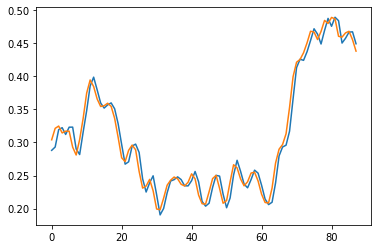

In [83]:
plt.figure()
plt.plot(np.arange(pred.shape[0]), pred[:, 0, :])
plt.plot(np.arange(pred.shape[0]), test_target[:, 0, :])
plt.show()

In [82]:
'GRU test loss: 0.0005160971645882546'

'GRU test loss: 0.0005160971645882546'

In [14]:
print(test_target.shape)

torch.Size([4, 88])


In [44]:
'RSP test loss: 0.0006836527948247121'

'RSP test loss: 0.0006836527948247121'

In [46]:
'Linear test loss: 0.00068016676907737'

'Linear test loss: 0.00068016676907737'